# Step Current Moments Based Summary Statiscits Development

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

from dap import DAPcython
from dap.dap_sumstats_moments import DAPSummaryStatsMoments

from dap.utils import obs_params_gbar, load_current
from scipy import stats as spstats

In [2]:
from dap.dap_sumstats_moments import DAPSummaryStatsMoments

## Simulate both protocols

In [3]:
dt = 1e-2
params, labels = obs_params_gbar()
data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
# data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_11d.dat'  # second best cell

In [4]:
# load the data
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
I_iv, v_iv, t_iv, t_on_iv, t_off_iv, dt_iv = load_current(data_dir, protocol='IV', ramp_amp=1)

In [5]:
# define and run the model
dap = DAPcython(-75, params)
U = dap.simulate(dt, t, I)
U_iv = dap.simulate(dt_iv, t_iv, I_iv)

## Comparison to sumstats for RAMP

In [6]:
x_1 = {'data': U.reshape(-1),
       'time': t,
       'dt': t[1]-t[0],
       'I': I[0]}


# calcualte summary statistics
sum_stats_mom = DAPSummaryStatsMoments(t_on, t_off, n_summary=17)
print('moments summary stats synt:', sum_stats_mom.calc([x_1]))

moments summary stats synt: [[-7.50384598e+01  3.59192465e-02 -7.33403721e+01  1.00000000e+00
   5.49425026e-01  2.97384948e-01  2.82555274e-01  2.86791992e-01
   1.52876475e+03  7.66240294e-01  2.48425609e+00  3.91145916e+00
   3.05474389e+01  1.13674673e+00  3.71889134e+00  1.20665454e+01]]


## Compute the new sumstats

In [7]:
print("cython:", timeit.timeit(lambda: dap.simulate(dt, t, I), number=int(1)))
print("cython:", timeit.timeit(lambda: dap.simulate(dt_iv, t_iv, I_iv), number=int(1)))

print(dt, dt_iv)

cython: 0.9930464979843237
cython: 1.1622483779792674
0.01 0.05


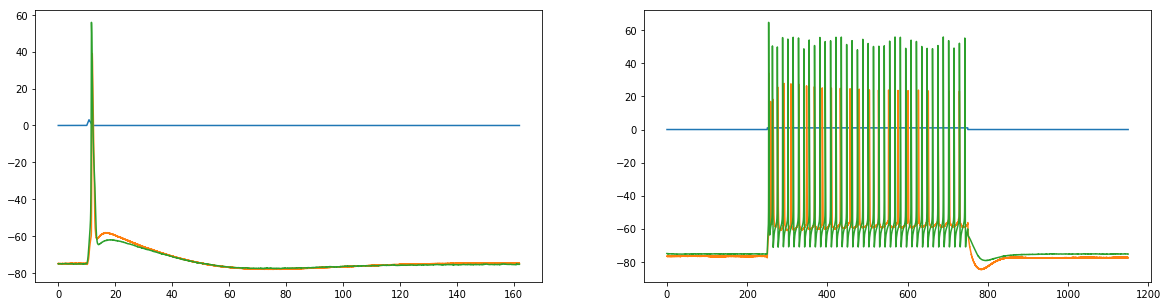

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(t, I)
ax[0].plot(t, v)
ax[0].plot(t, U)
ax[1].plot(t_iv, I_iv)
ax[1].plot(t_iv, v_iv)
ax[1].plot(t_iv, U_iv);

## Summary Statistics for Step Current

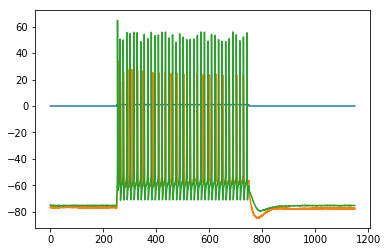

In [9]:
plt.plot(t_iv, I_iv)
plt.plot(t_iv, v_iv)
plt.plot(t_iv, U_iv);

In [10]:
data = U_iv
t = t_iv
t

array([0.00000e+00, 5.00000e-02, 1.00000e-01, ..., 1.14985e+03,
       1.14990e+03, 1.14995e+03])

In [11]:
x = {'data': data.reshape(-1)}
x

{'data': array([-74.98194867, -74.99495856, -74.99512006, ..., -75.26111356,
        -75.27530138, -75.27360824])}

In [12]:
N = data.shape[0]
dt = t[1] - t[0]
t_on = t_on_iv
t_off = t_off_iv

n_mom = 5
n_xcorr = 4

ind (array([    0,     1,     2, ..., 22997, 22998, 22999]), array([0, 0, 0, ..., 0, 0, 0]))


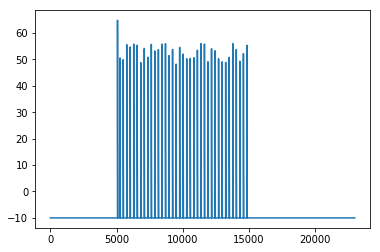

In [13]:
v = np.copy(data)

# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
print('ind', ind)

v[ind] = -10
plt.plot(v);

In [14]:
np.diff(data)

array([], shape=(23000, 0), dtype=float64)

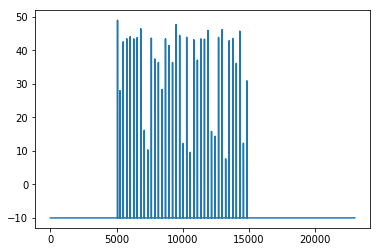

In [15]:
ind2 = np.where(np.diff(v, axis=0) < 0)
# print('ind2', ind2);

v[ind2] = -10
plt.plot(v);

In [16]:
t_on = t_on_iv

### Spike Times

In [17]:
spike_times = np.array(t)[ind2[0]]
spike_times;

In [18]:
spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]
spike_times_stim;

In [19]:
# plt.scatter(ind2[0], np.zeros_like(spike_times_stim))

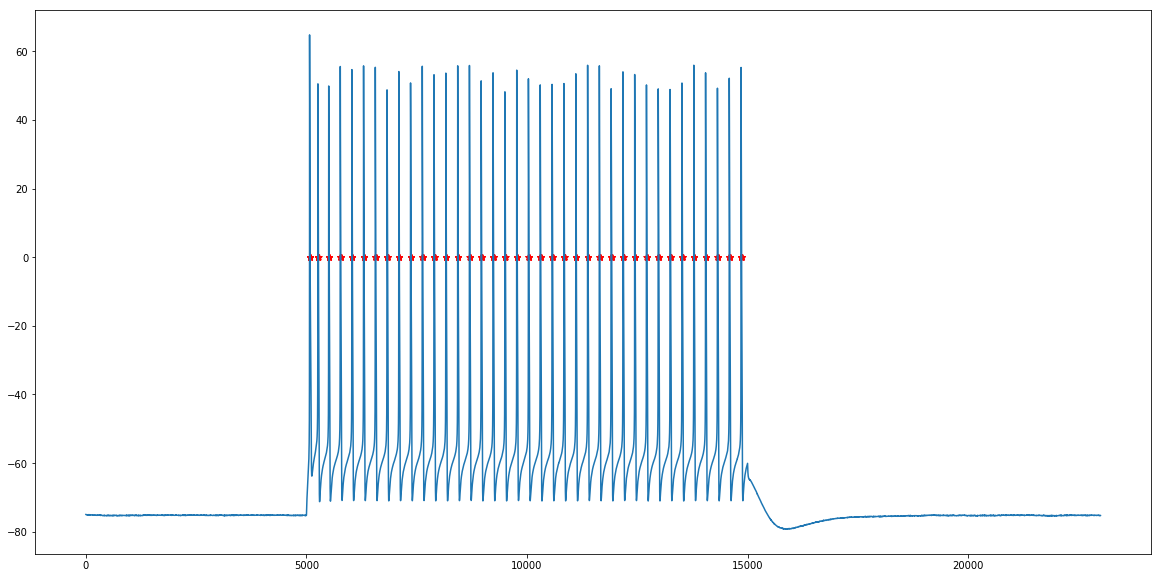

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(ind2[0], np.zeros_like(spike_times_stim), c='red', marker='*');
plt.plot(U_iv);
# plt.plot(v_iv);

In [21]:
# number of spikes
if spike_times_stim.shape[0] > 0:
    spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

In [22]:
len(spike_times_stim)

38

In [23]:
spike_times_stim

array([253.5 , 262.95, 275.2 , 288.3 , 301.45, 314.7 , 328.  , 341.3 ,
       354.65, 367.95, 381.25, 394.55, 407.95, 421.4 , 434.7 , 448.  ,
       461.45, 474.9 , 488.3 , 501.55, 514.95, 528.35, 541.8 , 555.3 ,
       568.65, 581.95, 595.3 , 608.7 , 622.  , 635.35, 648.7 , 662.1 ,
       675.6 , 689.  , 702.35, 715.8 , 729.2 , 742.6 ])

### Inter spike interval 

In [24]:
# ISI
ISI = np.diff(spike_times_stim).astype(float)
ind = [0,1,-1]
ISI1 = np.array([1000.]*3)
ISI1[0:np.maximum(0,spike_times_stim.shape[0]-1)] = ISI[ind[0:np.maximum(0,spike_times_stim.shape[0]-1)]]

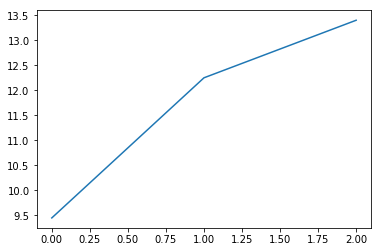

In [25]:
plt.plot(ISI1);

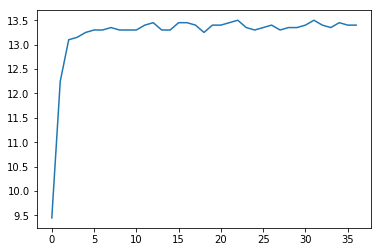

In [26]:
plt.plot(ISI);

In [27]:
ISI

array([ 9.45, 12.25, 13.1 , 13.15, 13.25, 13.3 , 13.3 , 13.35, 13.3 ,
       13.3 , 13.3 , 13.4 , 13.45, 13.3 , 13.3 , 13.45, 13.45, 13.4 ,
       13.25, 13.4 , 13.4 , 13.45, 13.5 , 13.35, 13.3 , 13.35, 13.4 ,
       13.3 , 13.35, 13.35, 13.4 , 13.5 , 13.4 , 13.35, 13.45, 13.4 ,
       13.4 ])

In [28]:
if spike_times_stim.shape[0] > 1:
    ISImom = np.array([np.mean(ISI),np.std(ISI)])
else:
    ISImom = np.array([t_off,0.])

ISImom

array([13.21891892,  0.65855609])

In [29]:
ISI1 = np.array([t_off-t_on,0.])
print(ISI1)
ISI1[0:np.maximum(0,spike_times_stim.shape[0]-1)] = ISImom[0:np.maximum(0,spike_times_stim.shape[0]-1)]

[500.   0.]


In [30]:
ISI1

array([13.21891892,  0.65855609])

In [31]:
# accommodation index
if spike_times_stim.shape[0] < 3:
   A_ind = 1000
else:
   ISI = np.diff(spike_times_stim)
   A_ind = np.mean( [ (ISI[i_min+1]-ISI[i_min])/(ISI[i_min+1]+ISI[i_min]) for i_min in range (0,ISI.shape[0]-1)] )

In [32]:
A_ind

0.0048301133355946645

In [33]:
# resting potential and std
rest_pot = np.mean(x['data'][t<t_on])
rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

In [34]:
# auto-correlations
x_on_off = x['data'][(t > t_on) & (t < t_off)]-np.mean(x['data'][(t > t_on) & (t < t_off)])
x_on_off

array([-20.61536983, -20.15419221, -19.72456785, ...,  -6.53623641,
        -6.48767331,  -6.44409656])

In [35]:
x_corr_val = np.dot(x_on_off,x_on_off)
x_corr_val

4664034.541355675

In [36]:
xcorr_steps = np.linspace(1./dt,n_xcorr*1./dt,n_xcorr).astype(int)
xcorr_steps

array([20, 40, 60, 80])

In [37]:
x_corr_full = np.zeros(n_xcorr)
x_corr_full

array([0., 0., 0., 0.])

In [38]:
# auto-correlations
x_on_off = x['data'][(t > t_on) & (t < t_off)]-np.mean(x['data'][(t > t_on) & (t < t_off)])
x_corr_val = np.dot(x_on_off,x_on_off.transpose())

xcorr_steps = np.linspace(1./dt, n_xcorr*1./dt, n_xcorr).astype(int)
x_corr_full = np.zeros(n_xcorr)

In [39]:
for ii in range(n_xcorr):
    x_on_off_part = np.concatenate((x_on_off[xcorr_steps[ii]:], np.zeros(xcorr_steps[ii])))  
    x_corr_full[ii] = np.dot(x_on_off,x_on_off_part)

x_corr1 = x_corr_full/x_corr_val

In [40]:
std_pw = np.power(np.std(x['data'][(t > t_on) & (t < t_off)]), np.linspace(3,n_mom,n_mom-2))
std_pw = np.concatenate((np.ones(1),std_pw))
moments = spstats.moment(x['data'][(t > t_on) & (t < t_off)], np.linspace(2,n_mom,n_mom-1))/std_pw


In [41]:
sum_stats_vec = np.concatenate((
        np.array([rest_pot,rest_pot_std,np.mean(x['data'][(t > t_on) & (t < t_off)])]),    
        np.array([spike_times_stim.shape[0]]),
        x_corr1,
        moments,
        ISI1,
    ))

In [42]:
sum_stats_vec

array([-7.52143154e+01,  3.07921447e-02, -5.36308971e+01,  3.80000000e+01,
        2.26723468e-01, -1.48549681e-01, -1.42322341e-01, -1.26320741e-01,
        4.66450099e+02,  2.98134699e+00,  1.19006842e+01,  4.86163312e+01,
        1.32189189e+01,  6.58556094e-01])

In [43]:
print('moments summary stats synt:', sum_stats_mom.calc([x_1]))

moments summary stats synt: [[-7.50384598e+01  3.59192465e-02 -7.33403721e+01  1.00000000e+00
   5.49425026e-01  2.97384948e-01  2.82555274e-01  2.86791992e-01
   1.52876475e+03  7.66240294e-01  2.48425609e+00  3.91145916e+00
   3.05474389e+01  1.13674673e+00  3.71889134e+00  1.20665454e+01]]
